In [12]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
import seaborn as sns
sns.set(style="whitegrid")



df = pd.read_csv('data/cleaned_df')
# Assuming 'created' is the datetime column indicating when the charge session was created
df['created'] = pd.to_datetime(df['created'])
df['ended'] = pd.to_datetime(df['ended'])
df['date'] = df['created'].dt.date  # Extract just the date part for daily aggregation
daily_demand = df.groupby('date')['kwhTotal'].sum().reset_index()  # Sum kWh per day

# Performance Prediction Model
This model aims to predict performance metrics such as duration or energy consumption per charge. If you want to include categorical variables like locationId or weekday, consider encoding these first.

Mean Absolute Error (MAE): 1.66
Mean Squared Error (MSE): 10.00
Coefficient of Determination (R²): -0.31


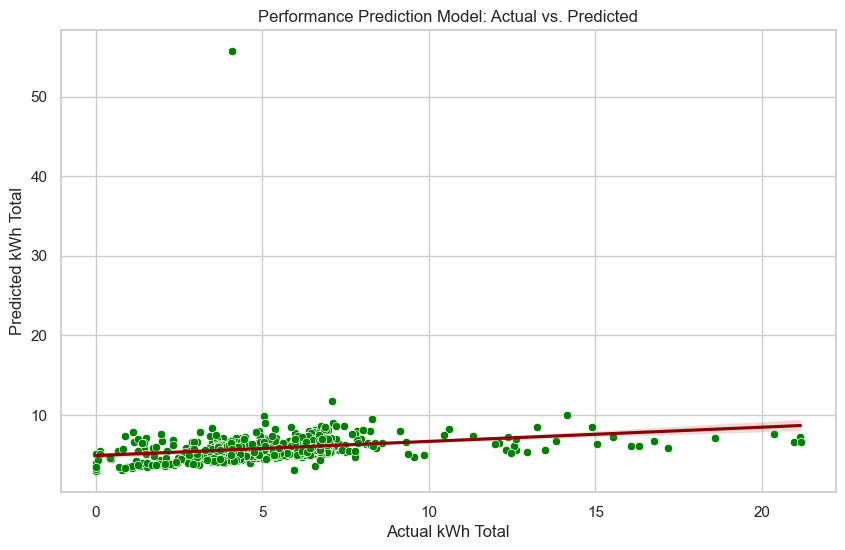

In [13]:
# Example features and target
features = ['chargeTimeHrs', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']  # Add more as needed
target = 'kwhTotal'

X = df[features]
y = df[target]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict and evaluate
predicted = model.predict(X_test)

mae = mean_absolute_error(y_test, predicted)
mse = mean_squared_error(y_test, predicted)
r2 = r2_score(y_test, predicted)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Coefficient of Determination (R²): {r2:.2f}")

# Visualization (Scatter plot of actual vs predicted)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=predicted, color='green')
sns.regplot(x=y_test, y=predicted, scatter=False, color='darkred')

plt.xlabel('Actual kWh Total')
plt.ylabel('Predicted kWh Total')
plt.title('Performance Prediction Model: Actual vs. Predicted')
plt.show()

_____

# Demand forecasting model
This model will predict daily usage patterns and demand at EV charging stations. Given that your data likely includes timestamps for each charging session, you can aggregate this to a daily level to forecast demand.

### Using a simple linear regression model to get started

Mean Absolute Error (MAE): 52.00
Mean Squared Error (MSE): 4170.05
Coefficient of Determination (R²): 0.17


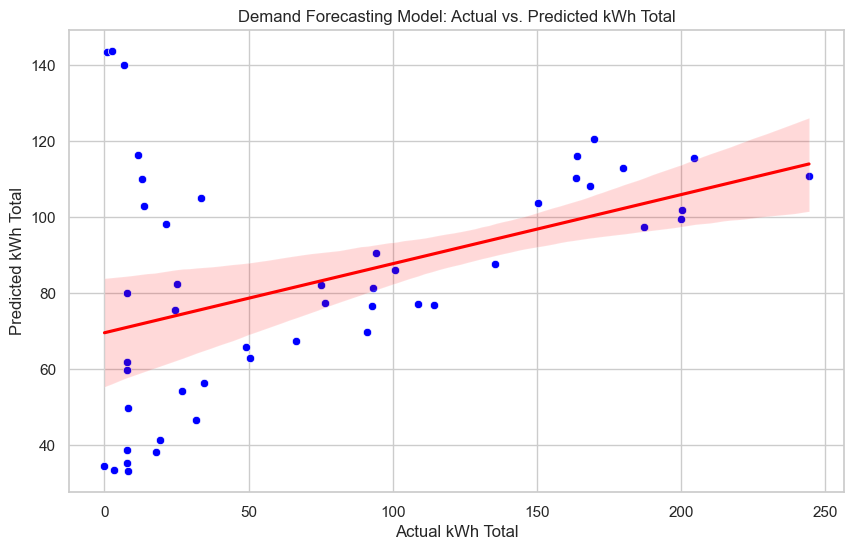

In [14]:

# Prepare data
daily_demand['day_of_year'] = pd.to_datetime(daily_demand['date']).dt.dayofyear
X = daily_demand[['day_of_year']]  # Predictor
y = daily_demand['kwhTotal']  # Response

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict and plot
predicted = model.predict(X_test)

mae = mean_absolute_error(y_test, predicted)
mse = mean_squared_error(y_test, predicted)
r2 = r2_score(y_test, predicted)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Coefficient of Determination (R²): {r2:.2f}")

# Visualize
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=predicted, color='blue')
sns.regplot(x=y_test, y=predicted, scatter=False, color='red')

plt.title('Demand Forecasting Model: Actual vs. Predicted kWh Total')
plt.xlabel('Actual kWh Total')
plt.ylabel('Predicted kWh Total')
plt.show()


### Using more advanced time series model ARIMA 

Since we don't have actual values to validate the ARIMA model, we will split the existing data into training and testing segments. 

In [21]:
df = pd.read_csv('data/cleaned_df.csv', parse_dates=['created', 'ended'])
df['date'] = df['created'].dt.date  # Extract just the date part for daily aggregation
daily_demand = df.groupby('date')['kwhTotal'].sum().reset_index()  # Sum kWh per day
daily_demand['date'] = pd.to_datetime(daily_demand['date'])  # Ensure 'date' is datetime
daily_demand.set_index('date', inplace=True)

In [22]:
result = adfuller(daily_demand['kwhTotal'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# Interpretation
if result[1] > 0.05:
    print("Series is not stationary. Differencing is needed.")
else:
    print("Series is stationary.")
if result[1] > 0.05:
    daily_demand['diff_kwhTotal'] = daily_demand['kwhTotal'].diff().dropna()

    # Check stationarity again
    result = adfuller(daily_demand['diff_kwhTotal'].dropna())
    print('ADF Statistic after differencing:', result[0])
    print('p-value after differencing:', result[1])

ADF Statistic: -1.0593855089212858
p-value: 0.7309938890172751
Series is not stationary. Differencing is needed.
ADF Statistic after differencing: -8.468409055523022
p-value after differencing: 1.500522880498718e-13


In [23]:

model_arima = auto_arima(daily_demand['kwhTotal'], seasonal=False, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
print(model_arima.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2492.541, Time=0.54 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2621.657, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2620.994, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2619.657, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.61 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.77 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.77 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.81 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=2495.809, Time=0.20 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 5.446 seconds
 

In [24]:
train_data = daily_demand['kwhTotal'][:-30]  # All data except last 30 days
test_data = daily_demand['kwhTotal'][-30:]  # Last 30 days


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Mean Absolute Error (MAE): 73.12
Mean Squared Error (MSE): 7324.85
Root Mean Squared Error (RMSE): 85.59


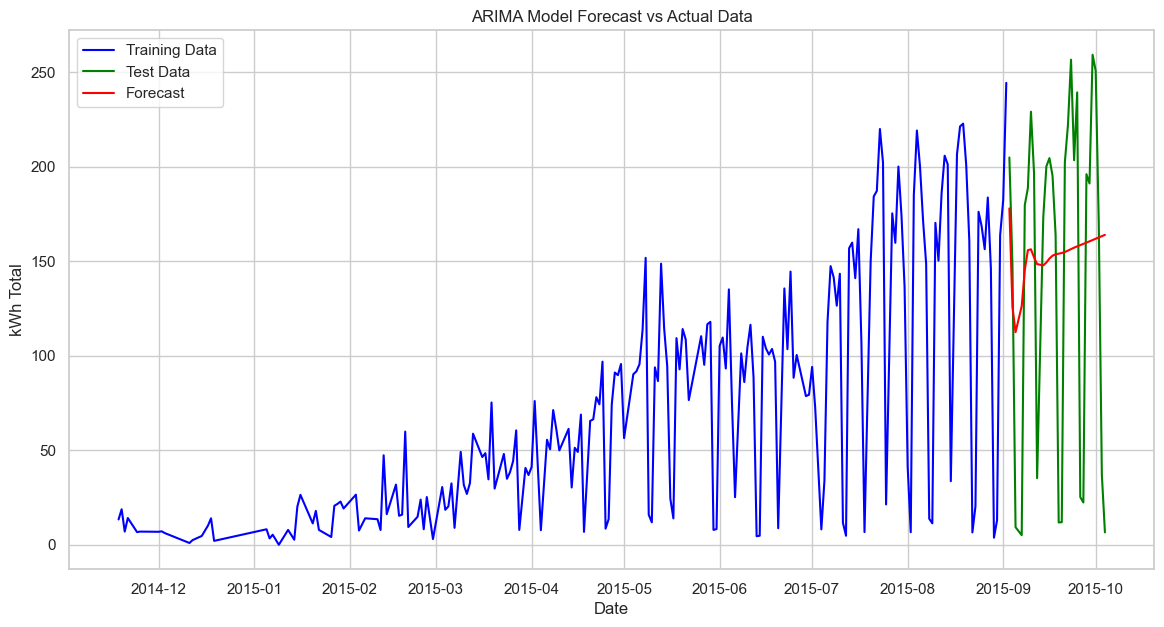

In [26]:


# Fit model on training data
model_arima.fit(train_data)

# Forecast
forecast = model_arima.predict(n_periods=30)
forecast_index = test_data.index  # Use the index of the test_data for the forecast

# Calculate performance metrics
mae = mean_absolute_error(test_data, forecast)
mse = mean_squared_error(test_data, forecast)
rmse = np.sqrt(mse)

# Print out the performance metrics
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Plotting
plt.figure(figsize=(14, 7))
sns.lineplot(data=train_data, label='Training Data', color='blue')
sns.lineplot(data=test_data, label='Test Data', color='green')
sns.lineplot(x=forecast_index, y=forecast, label='Forecast', color='red')

plt.title('ARIMA Model Forecast vs Actual Data')
plt.xlabel('Date')
plt.ylabel('kWh Total')
plt.legend()
plt.show()


____
